# Multiple imaging

Let's explore simulation of signals generated by neutron stars sufficiently compact to generate multiple images of a subset or even all of the surface. En route we demonstrate correctness for an oblate surface embedded in an ambient Schwarzschild spacetime by calling *four* integrators whose algorithms are (vastly) different. In particular integrators that discretise the surface will be compared to an integrator that discretises a moderately distant image-plane; integrators that employs these distinct discretisation schemes in the computational domain are effectively orthogonal and provide strong internal validation of the ray-tracing backend used for statistical computation in practice. We will also replace numerical primary-image ray solutions (lensing integral computed via numerical quadrature and inversion by spline interpolation) with a high-order lensing integral expansion via linking to the [rayXpanda](https://github.com/ThomasEdwardRiley/rayXpanda) package.

The unexecuted notebook for this tutorial may be found in a GitHub repository:

``` bash
git clone https://github.com/ThomasEdwardRiley/xpsi_workshop.git </path/to/clone>

cd </path/to/clone>/tutorials/v0.5/
```

You can use the default atmosphere extension modules ``xpsi/surface_radiation_field/archive/hot/blackbody.pyx``  and ``xpsi/surface_radiation_field/archive/local_variables/uniform.pyx``. To run this tutorial, you should therefore be able to simply use the default ``xpsi/surface_radiation_field/hot.pyx`` extension and ``xpsi/surface_radiation_field/local_variables.pyx`` that are automatically compiled when X-PSI is installed.

The first part of this tutorial largely follows the *Global surface emission* tutorial. We use a surface radiation field that is globally uniform to compare all integrators. We use an effectively spherical star by entering the limit of zero spin.

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

from IPython.display import Image

import xpsi
from xpsi import Parameter

try:
    xpsi.cellmesh
except AttributeError:
    pass
else:
    # use the override switch to deactivate external library for now
    # this means that lensing integral solutions will be fully numerical
    xpsi.cellmesh.__deactivate_rayXpanda__ = False

from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius, _csq, _km, _M_s, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 0.5.3               |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


First we need to do some setup of the ambient spacetime and the surface embedded in it that the photosphere exists on.

In [2]:
bounds = dict(frequency = (0.1, 205.0),
              distance = (0.1, 1.0),                     # (Earth) distance
              mass = (1.0, 3.0),                         # mass
              radius = (3.0 * gravradius(1.0), 16.0),    # equatorial radius
              cos_inclination = (0.0, 1.0))              # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=0.1)) # spherical star

Creating parameter:
    > Named "frequency" with bounds [1.000e-01, 2.050e+02] and initial value 1.000e-01.
    > Spin frequency [Hz].


Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].


Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].


Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].


Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.




## Default (phase-invariant)

First we invoke a globally uniform temperature field. There is no azimuthal dependence, meaning that the signal generated by the star is time-invariant. We are in need of an object that embeds a *globally* discretised surface into the ambient spacetime and exposes methods for integration over solid angle on our sky. 

In [3]:
bounds = dict(temperature = (None, None))

everywhere = xpsi.Everywhere(time_invariant=True,
                             bounds=bounds,
                             values={}, # no fixed/derived variables
                             sqrt_num_cells=512, # in colatitude, and in azimuth separately
                             num_rays=1024, # O(1000) useful for higher-order images
                             num_leaves=512, # specify leaves if time-dependent
                             num_phases=100, # of the output signal
                             image_order_limit=None) # as many images as possible within resolution

Creating parameter:
    > Named "temperature" with bounds [3.000e+00, 7.000e+00].
    > log10(effective temperature [K] everywhere).




We are free to subclass [Everywhere](everywhere.rst#xpsi.Everywhere.Everywhere) and implement custom functionality beyond the simple default above. The argument specifying the number of rays has the familiar meaning. The argument for the number of cells is now used to discretise the surface in azimuth and colatitude with respect to the stellar rotation axis, as was the case for the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) module. The new argument ``time_invariant`` declares whether or not the surface radiation field is dependent on azimuth; if it is independent of azimuth, a faster integrator is called.

Now we need an instance of [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) that we can feed our ``everywhere`` object to. If we are not imaging the photosphere or we are satisfied with the default behaviour we do *not* need to subclass [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere).

In [4]:
class derive(xpsi.Derive):
    def __init__(self):
        pass
    def __call__(self, boundto, caller = None):
        global spacetime
        return spacetime['frequency']

In [5]:
photosphere = xpsi.Photosphere(hot = None, elsewhere = None, everywhere = everywhere,
                               values=dict(mode_frequency = derive()))

Creating parameter:
    > Named "mode_frequency" that is derived from ulterior variables.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].




In [6]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

Let's check the vector of parameter values in the ``Star`` instance and the other objects it encapsulates references to.

In [7]:
star

Free parameters
---------------
frequency: Spin frequency [Hz].
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
temperature: log10(effective temperature [K] everywhere).

We assign parameter values and update the star as follows:

In [8]:
# (Earth) distance
star['distance'] = 0.33
# gravitational mass
star['mass'] = 2.7088795
# coordinate equatorial radius
star['radius'] = 12.0
# (Earth) inclination to rotation axis
star['cos_inclination'] = math.cos(1.0)
# isotropic blackbody temperature
star['temperature'] = 6.3

star.update()

The temperature is chosen to be something appropriately hot for the energy range, so that the specific flux at the lowest energies is *not* dominated by bright stellar limb, which will be the case for targets in X-ray telescope wavebands. More on this later.

In [9]:
spacetime.R_r_s # rather compact! effectively @ the Schwarzschild photon sphere

1.500000264007786

Let's see what the maximum deflection is calculated to be conditional on the resolution:

In [10]:
everywhere._maxDeflection[0]/xpsi.global_imports._pi

5.323888913317964

A true maximum deflection of this value, for a spherical star, would mean a subset of the stellar surface would be imaged *six* times. This subset is defined by having a *principal* deflection of $\psi\lesssim(1-0.3239)\pi$, meaning a spherical cap of this angular radius centred on the direction between Earth and the centre of the star. The subset of the surface with *principal* deflection of $\psi\gtrsim(1-0.3239)\pi$, and by definition less than $\pi$, is *only* imaged *five* times.

Let's compute the incident specific flux signal, up to some constant coefficient.

In [11]:
energies = np.logspace(-2.0, np.log10(3.0), 100, base=10.0)

In [12]:
photosphere.integrate(energies=energies, threads=4) # calls to xpsi/cellmesh/integrator_for_time_invariance.pyx

The signal is time-invariant and therefore we need to copy the spectrum to a sequence of matrix columns to get the desired energy-phase signal matrix:

In [13]:
temp_int1 = np.tile(photosphere.signal[0][0], (1,len(everywhere.phases_in_cycles)))

We need a helper function to plot the signal, normalised to the maximum specific flux:

In [14]:
from xpsi.tools import phase_interpolator

def plot_2D_pulse(z, x, shift, y, ylabel,
                  num_rotations=5.0, res=5000, normalise=True,
                  cm=cm.viridis, vmin=None, vmax=None, label=None):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = (12,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator(new_phases,
                                      x,
                                      np.ascontiguousarray(z), shift)
    if normalise:
        interpolated /= np.max(interpolated)
    
    if vmin is None:
        vmin = np.min(interpolated)
        
    if vmax is None:
        vmax = np.max(interpolated)
  
    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated,
                             cmap = cm,
                             vmin = vmin,
                             vmax = vmax,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 5.0])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax)
    
    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = AutoLocator())

    cb.set_label(label=label or r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    cb.outline.set_linewidth(1.0)
    
rcParams['text.usetex'] = False
rcParams['font.size'] = 18.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

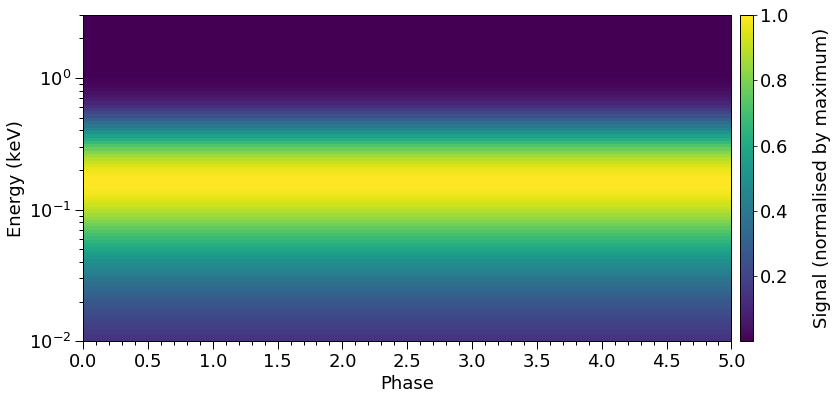

In [15]:
plot_2D_pulse(temp_int1,
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)')

If we declare the signal as time-dependent, a different integrator is called:

In [15]:
everywhere.time_invariant = False # switches to xpsi/cellmesh/integrator.pyx

In [16]:
photosphere.integrate(energies=energies, threads=4)

In [17]:
temp_int2 = photosphere.signal[0][0].copy()

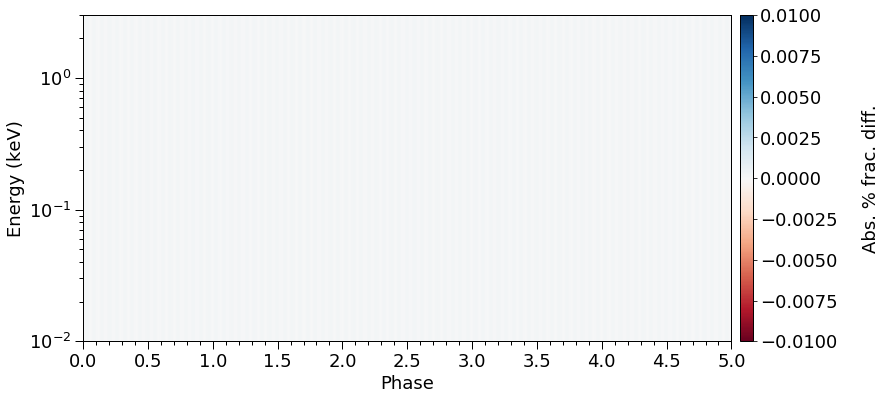

In [18]:
plot_2D_pulse(100.0*(temp_int2/temp_int1 - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-0.01, # if None just uses minimum abs. diff.
              vmax=0.01,  # if None just uses maximum abs. diff.
              normalise = False)

In [23]:
everywhere._integrator_toggle = True # switch to final integrator that discretises surface, xpsi/cellmesh/integrator_for_azimuthal_invariance.pyx, for testing

In [24]:
photosphere.integrate(energies=energies, threads=4)

In [25]:
temp_int3 = photosphere.signal[0][0].copy()

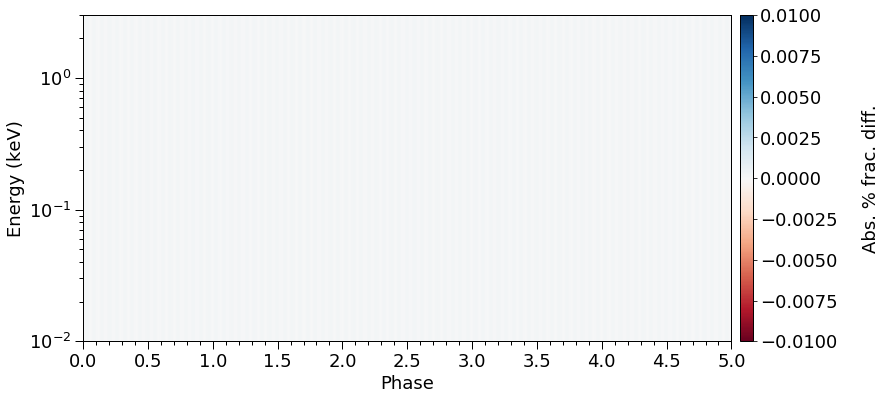

In [27]:
plot_2D_pulse(100.0*(temp_int3/temp_int1 - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-0.01, # if None just uses minimum abs. diff.
              vmax=0.01,  # if None just uses maximum abs. diff.
              normalise = False)

We can also call a fourth integrator. This integrator is more general purpose, and thus inexorably more expensive to call. First we need to force the spacetime to be static (otherwise univeral relations are invoked based on the stellar spin frequency as set above):

In [28]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

Now we call the integrator. The integrator discretises a distant image plane instead of the stellar surface. The *image* of the star is spatially resolved on the image plane. The integrator yields four-dimensional information about the signal. We trace a set of rays from the image plane to the star; the set is roughly equal in cardinality to the number of cells that discretise the surface above. Note that when this extension module is called, some output for diagnostics is directed to the terminal in which you launched this Jupyter notebook.

In [29]:
photosphere.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 1024,
                  # squeeze rays towards limb where higher-order images are
                  image_plane_radial_increment_power=0.2, 
                  threads = 4,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12) # ray relative tolerance

Imaging the star...
Commencing ray tracing and imaging...
Ray tracing complete.
Ray set cached.
Phase-resolved specific flux integration complete.
Star imaged.


We now compare the signal to those computed above. The phase-energy resolved specific flux signal (integrated over sky solid angle) can be accessed through the ``images`` property of the ``photosphere`` object. The elements of this property also contain image plane coordinates, stellar surface coordinates, and quantities such as the specific *photon* intensity as a function of phase, energy, and sky direction (image plane coordinates). Note that the units of the specific flux signal are photons/cm$^{2}$/s/keV because it has already been scaled by the square of the distance. The signals generated by the integrators above have not been scaled by the square of the distance (an implementation specific detail that is susceptible to change in the future).

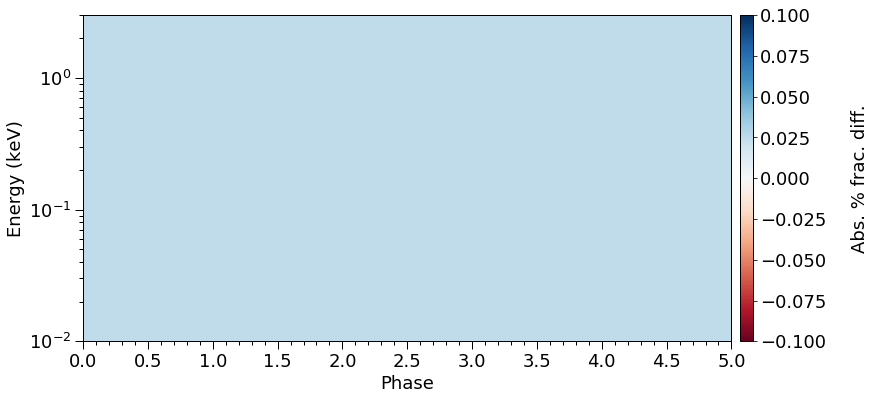

In [30]:
plot_2D_pulse(100.0*(photosphere.images[0]*spacetime.d_sq/temp_int1 - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-0.1,
              vmax= 0.1,
              normalise = False)

Let's make a comparison of the integrators in one plot:

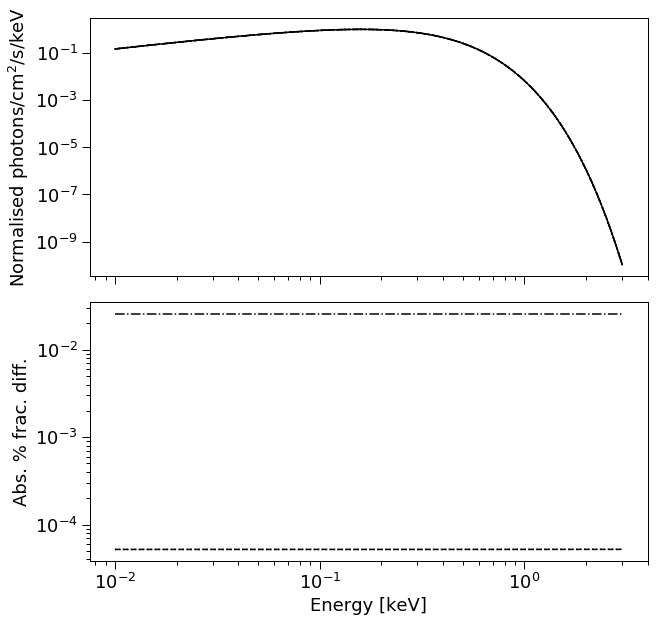

In [32]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211)

MAX = np.max(temp_int1[:,0])

ax.plot(energies,
         temp_int1[:,0]/MAX,
         'k-')

ax.plot(energies,
         temp_int2[:,0]/MAX,
         'k--')

ax.plot(energies,
         temp_int3[:,0]/MAX,
         'k:')

ax.plot(energies,
         photosphere.images[0][:,0]*spacetime.d_sq/MAX,
         'k-.')

ax.set_xscale('log')
ax.set_ylabel(r'Normalised photons/cm$^{2}$/s/keV')
ax.set_yscale('log')
ax.xaxis.set_ticklabels([])
veneer((None, None), (None, None), ax)

ax = fig.add_subplot(212)

ax.plot(energies,
         100.0*np.abs(temp_int2[:,0]/temp_int1[:,0] - 1.0),
         'k--')

ax.plot(energies,
         100.0*np.abs(temp_int3[:,0]/temp_int1[:,0] - 1.0),
         'k:')

ax.plot(energies,
         100.0*np.abs(photosphere.images[0][:,0]*spacetime.d_sq/temp_int1[:,0] - 1.0),
         'k-.')

ax.set_xscale('log')
ax.set_xlabel('Energy [keV]')

ax.set_yscale('log')
ax.set_ylabel('Abs. % frac. diff.')

veneer((None, None), (None, None), ax)

plt.subplots_adjust(hspace=0.1)

The differences can be reduced, within the scope of a given algorthm, by defining higher resolution integration settings. The integration algorithms are so distinct that this consistency validates the tools internally; verification against external packages would nevertheless permit stronger guarantees of robustness. The simple package [rayXpanda](https://github.com/ThomasEdwardRiley/rayXpanda) offered a weak validation (i.e., for primary images only) of the Schwarzschild ray integration routines called by the surface-discretisation signal integrators. In fact, let's now link rayXpanda into X-PSI to make a final validating cross-check of the primary image computation: X-PSI calculating the lensing integral $\psi(\alpha;u)$ and the convergence $\sim\partial\cos\alpha/\partial\cos\psi$ via numerical quadrature and inversion by spline interpolation, and rayXpanda calculating a high-order integral expansion to simultaneously evaluate $\alpha(\psi;u)$ and the convergence. Here the deflection $\psi$ depends on the ray angle to the radial direction (in a local Eulerian frame) and on the compactness coordinate $u=r_{\rm s}/R(\theta;M,\Omega,R_{\rm eq})$.

## Linking in rayXpanda

If you do not have rayXpanda installed, the surface-discretisation integrators will simply revert to the default behaviour already shown above.

If rayXpanda is linked in, then it replaces the primary image lensing calculation up to some deflection limit. There are however two behaviours to be of that we demonstrate below. If the deflection limit is too low high but below $\pi$ radians (by definition), then the expansion truncation error manifests. And non-intuitively, if the deflection limit is too low, then due to the design of the algorithm to support inclusion of higher-order images, the numerical solution will become inaccurate for small deflections. If rayXpanda is not linked in, a different numerical scheme is substituted in that handles primary images that are deflected by $\psi<\pi/2$ radians; the rayXpanda expansion is highly consistent with this numerical (quadrature + interpolation) solution as shown below.

In [97]:
%%capture

try:
    xpsi.cellmesh
except AttributeError:
    pass
else:
    # use the override switch to deactivate external library for now
    # this means that lensing integral solutions will be fully numerical
    xpsi.cellmesh.__deactivate_rayXpanda__ = False
    everywhere.time_invariant = True # calls to xpsi/cellmesh/integrator_for_time_invariance.pyx
    everywhere.image_order_limit = 0 # in case it changed anywhere, e.g., cells executed out of order
    limits = np.linspace(0.01, 0.99*math.pi, 100)
    def helper(lim):
        xpsi.set_rayXpanda_deflection_limit(lim)
        photosphere.integrate(energies=energies, threads=4)
        return np.max(100.0*np.abs(photosphere.signal[0][0][:,0]/temp_int1[:,0] - 1.0))
    
    errors = []
    for lim in limits:
        errors.append(helper(lim))

If we do not capture the output, the warning below will be printed a number of times:

Warning: invoking rayXpanda for a signal integration over a subdomain of the stellar image.

Warning: the larger the primary image subdomain chosen for rayXpanda calls,

Warning: the larger the rayXpanda expansion truncation error.

Warning: you can control this by setting the rayXpanda deflection limit manually.

Warning: please use the top-level function xpsi.set_rayXpanda_deflection_limit(float).

Warning: please refer to the documentation at https://thomasedwardriley.github.io/rayXpanda/theory

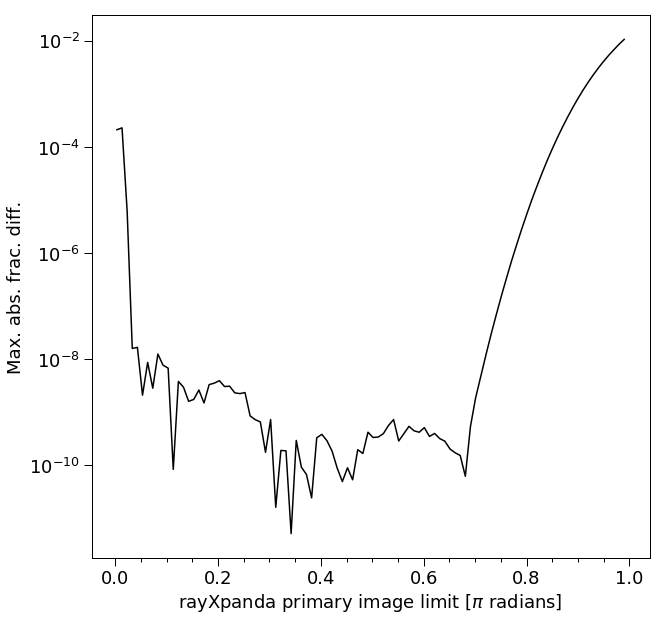

In [100]:
try:
    xpsi.cellmesh
except AttributeError:
    pass
else:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.plot(limits/xpsi.global_imports._pi, np.array(errors)/100.0, 'k-')

    ax.set_xlabel('rayXpanda primary image limit [$\pi$ radians]')

    ax.set_yscale('log')
    ax.set_ylabel('Max. abs. frac. diff.')

    veneer((0.05, 0.2), (None, None), ax)

The default rayXpanda deflection limit, if the library is linked in, is also $\psi<\pi/2$ radians. If you are interested in a straightforward comparison of the high-order rayXpanda expansion and the default numerical primary image scheme for $\psi<\pi/2$, please refer to the rayXpanda documentation for demonstrative plots.

## Decreasing the image order limit

For integrators that discretise the stellar surface we can straightforwardly control the limiting image order to try to sum up to. If the image order is conservative, the integrators automatically detect invisibility and truncate. Note that the sum is executed from low- to high-order, which generally means adding small numbers to much larger numbers, and thus in principle accuracy loss, but the number magnitude decays very rapidly with order so the contribution from combining higher-order images first shouldn't make an importance difference. If higher-order images are visible, they are simply missed because of enforced truncation. It follows that because the flux contribution from higher-order images (even at fixed phase and energy) decays with order, setting a limit of three images or even two images is going to be entirely sufficient in practice. On the other hand, not setting a limit won't affect integration time in an important way for less compact stars, but if prior support extends to very compact stars, the computation time increases by a factor of a few, until the resolution limit is reached.

We will give some guidance about prior support after we factor in higher spins below.

In [16]:
everywhere.time_invariant = True # calls to xpsi/cellmesh/integrator_for_time_invariance.pyx

In [17]:
def helper(order):
    everywhere.image_order_limit = order 
    photosphere.integrate(energies=energies, threads=4)
    return photosphere.signal[0][0].copy()

In [18]:
xpsi.cellmesh.__deactivate_rayXpanda__ = True

In [19]:
temp_int1_rayX_1 = helper(1) # primary image only
temp_int1_rayX_2 = helper(2) # up to secondary images
temp_int1_rayX_3 = helper(3) # up to tertiary images
temp_int1_rayX_4 = helper(4) # and so on...
temp_int1_rayX_5 = helper(5) # we will compare to the adaptive computation above   

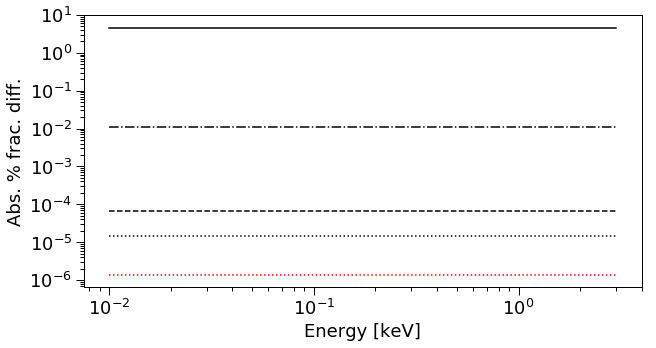

In [22]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.plot(energies,
     100.0*(-temp_int1_rayX_1[:,0]/temp_int1[:,0] + 1.0),
     'k-')

ax.plot(energies,
         100.0*(-temp_int1_rayX_2[:,0]/temp_int1[:,0] + 1.0),
         'k-.')

ax.plot(energies,
         100.0*(-temp_int1_rayX_3[:,0]/temp_int1[:,0] + 1.0),
         'k--')

ax.plot(energies,
         100.0*(-temp_int1_rayX_4[:,0]/temp_int1[:,0] + 1.0),
         'k:')

ax.plot(energies,
         100.0*(-temp_int1_rayX_5[:,0]/temp_int1[:,0] + 1.0),
         'r:')

#ax.plot(energies,
#         100.0*np.abs(photosphere.images[0][:,0]*spacetime.d_sq/temp_int1[:,0] - 1.0),
#         'b-.')

ax.set_xscale('log')
ax.set_xlabel('Energy [keV]')

ax.set_yscale('log')
ax.set_ylabel('Abs. % frac. diff.')

veneer((None, None), (None, None), ax)

For this compact star only the secondary images are demonstrably important, with a massive increase in accuracy. We also show again the level of validation achieved via image-plane calculation in *blue*. To demonstrate either convergence of the image-plane and surface discretisation algorithms, or that the algorithms need to be improved to be accurate for image orders beyond two, we'd need to tune up the resolution settings. In particular we sacrificed primary image resolution when squeezing the image-plane rays towards the stellar limb, given that we were also in pursuit of visualisation the higher-order image squeezing. Resolution settings that target flux accuracy will improve the consistency.

## Multiple images

Let's use the cached ray map to try to visualise the multiple imaging:

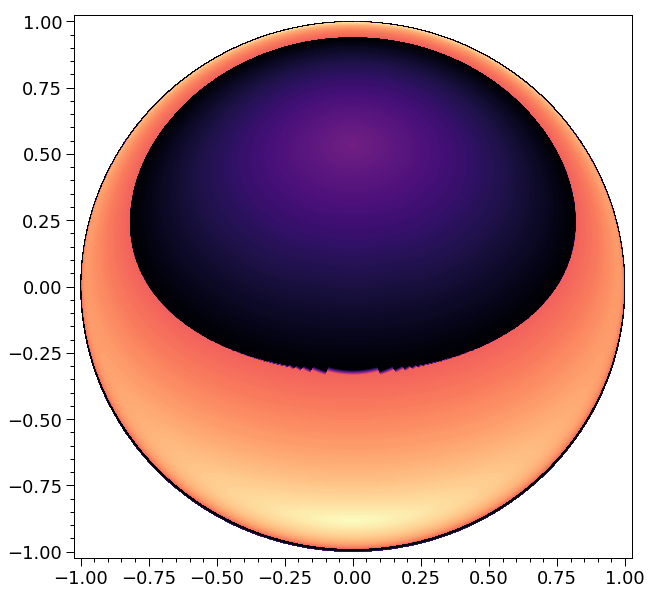

In [33]:
fig = plt.figure(figsize=(10,10))

ref = photosphere.images[3].copy()
ref[ref > math.pi/2.0] *= -1.0
plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the colatitude

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
veneer((0.05,0.25), (0.05,0.25), ax)

The artefact near the origin along the equator is because we squeezed the image-plane polar ray set towards the  image boundary, leaving fewer rays around the origin for accurate contour computation (via Delaunay triangulation).

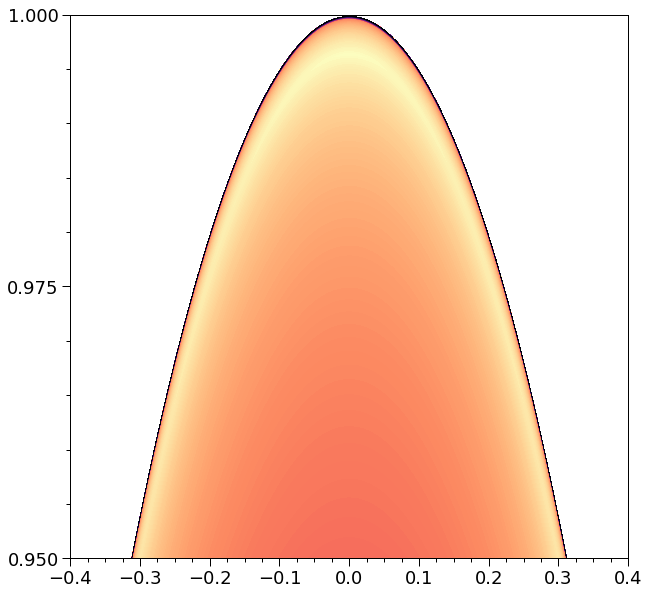

In [34]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([0.95, 1.0])
veneer((0.025,0.1), (0.005,0.025), ax)

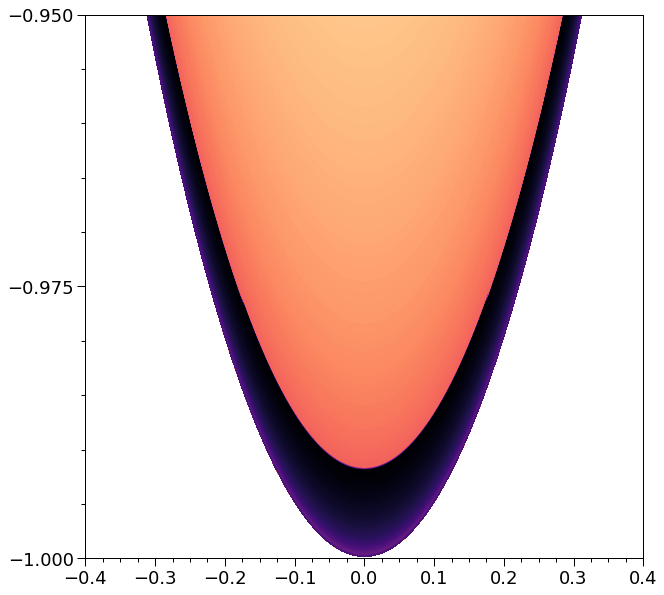

In [35]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-1.0,-0.95])
veneer((0.025,0.1), (0.005,0.025), ax)

Let's zoom in again to see the insane squeezing of just the third image of the southern pole:

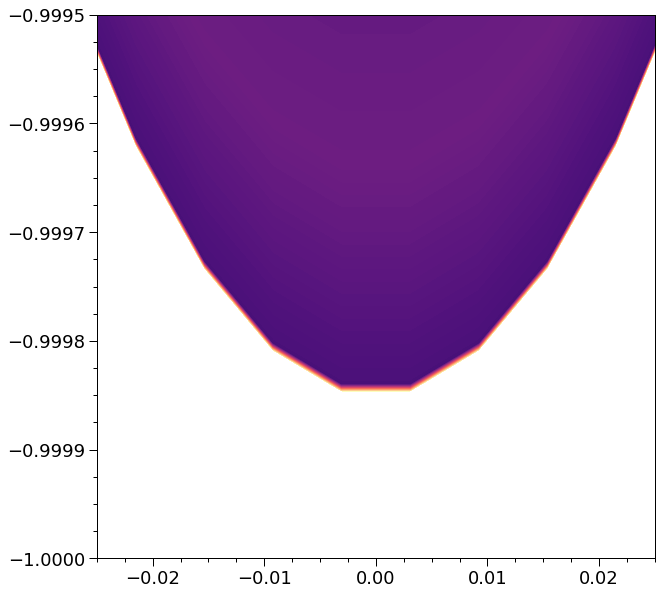

In [47]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.025,0.025])
ax.set_ylim([-1.0,-0.9995])
_ = veneer((0.0025,0.01), (0.000025,0.0001), ax)

We'd evidently need more rays and probably more accurate ray tracing (given that in theory the image of this effectively spherical star should extend to $y=\pm1$ and $x=\pm1$) to resolve even these third-order images if they contributed to the flux in an important way. We continue discussion of performance below.

Let's first plot the azimuth map to distinguish images:

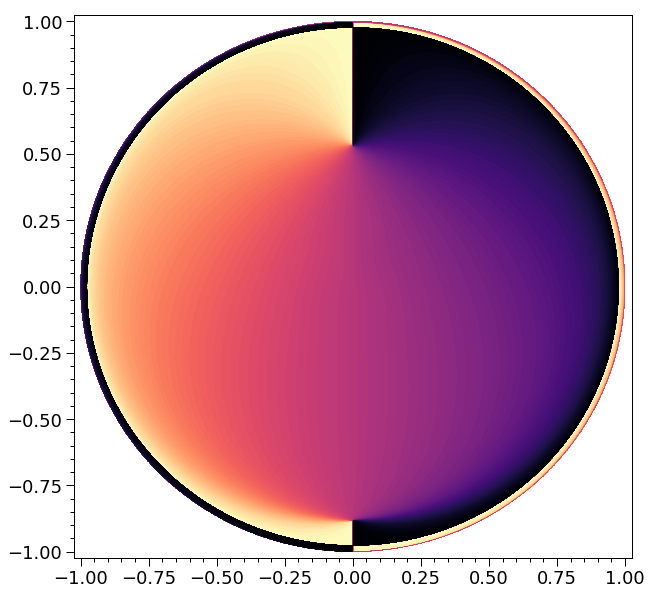

In [36]:
fig = plt.figure(figsize=(10,10))

phi = np.copy(photosphere.images[4][...])

for i in range(len(phi)):
    
    if phi[i] > -100.0:
        if phi[i] > math.pi:
            while phi[i] > math.pi:
                phi[i] -= 2.0 * math.pi
        elif phi[i] < -math.pi:
            while phi[i] < -math.pi:
                phi[i] += 2.0 * math.pi

phi_lvls = np.linspace(np.min(phi[phi > -100.0]),
                       np.max(phi[phi > -100.0]), 100)

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the azimuth

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
veneer((0.05,0.25), (0.05,0.25), ax)

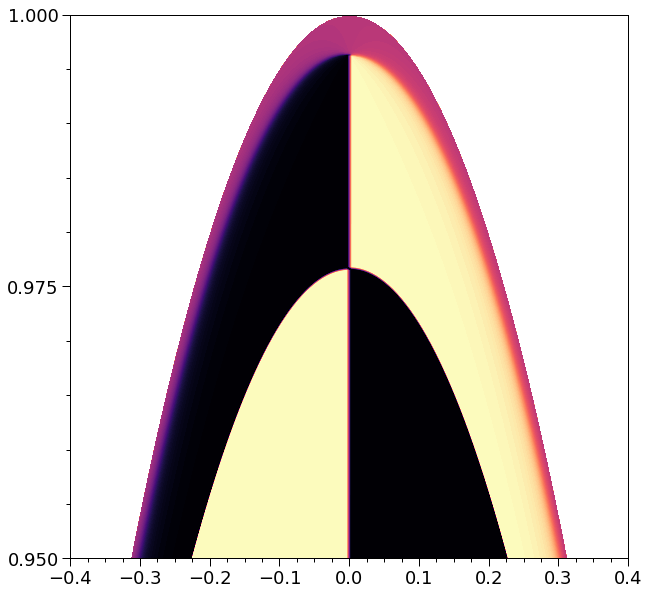

In [48]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([0.95, 1.0])
veneer((0.025,0.1), (0.005,0.025), ax)

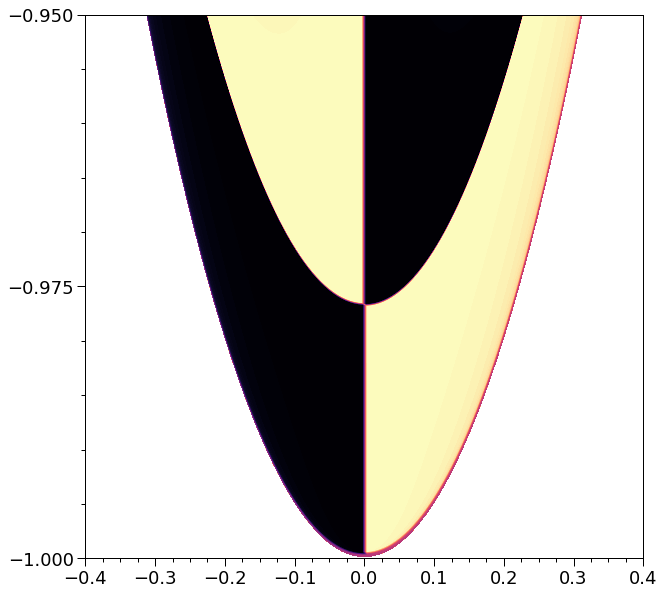

In [49]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-1.0,-0.95])
veneer((0.025,0.1), (0.005,0.025), ax)

## Millisecond pulsar spin (phase-invariant)

Let's spin the star up to include two additional effects: relativistic beaming of the surface emission and rotational deformation (oblateness). The former means that for an observer substantially inclined to the rotational axis, the flux at (gravitationally blueshifted) energies beyond a thermal knee in the photosphere specific intensity spectrum becomes dominated by images at the edge of the stellar image on our sky (i.e., at the stellar limb). Note that another way to weight the flux integral towards the stellar limb is to have temperature inversion in the atmosphere, leading to bright near-tangential emission, but the effect is not as a strong as tuning up to millisecond spin periods and higher.

Only at energies well beyond a thermal knee in the surface emission will the relativistic beaming mean that the flux is dominated by the brightness at the stellar limb (when there is somewhat uniform, global surface emission as assumed here), where the high-order images will be squeezed. The brightness of near-tangential emission after beaming partially counteracts the solid angle decay with image order, in such a case, but will not realistically ever mean high-order images contribute more flux at some energy. However, X-ray telescopes will generally be sensitive to softer emission where there are *far* more counts, meaning relative insensitivity of a well-performing likelihood function jointly over the instrument waveband to flux integration error in the vicinity of the stellar limb.

Realistically, if a surface does not radiate somewhat unformly in the instrument waveband, leading to pulsed emission, effectively the same reasoning applies to the importance of accurately calculating the flux at phases where the flux is dominated by the signal from the stellar limb where the limb is constituted by only primary images, simply because of geometric projected effects. This is without or without additional strong relativistic beaming effects leading to flux (at energies beyond a thermal knee in the surface emission spectrum) being dominated by the contribution from the relevant radiating regions when they reach the stellar limb on the approaching side of the star.

Oblateness has the effect of increasing the maximum deflection that can be attained by a point on the surface, relative to an unperturbed spherical *background* solution. Some points, such as the locus in the vicinity of the equator only lower in maximum deflection. In the vicinities of the poles, points gain in maximum deflection. In these cases the surface normal remains effectively radial. For intermidate points between a pole and the equator, the maximum deflection generally increases due to tilt even if the compactness coordinate decreases, but also due to tilt, some images (either even or odd beyond some order) are also lost. This is because the maximum deflection depends on the ray direction aside from the angle subtended to the radial direction.

In [13]:
spacetime['frequency'] = 205.0 # ~J0030 spin

We'll reset the mass so that the oblate surface lies entirely, and barely just outside ambient Schwarzschild photon sphere:

In [14]:
star['mass'] = 2.695 # choose mass so that surface lies entirely, and barely just outside photon sphere

In [15]:
star.update()

In [16]:
everywhere.time_invariant = True

In [17]:
photosphere.integrate(energies=energies, threads=4)

In [18]:
rtemp_int1 = np.tile(photosphere.signal[0][0], (1,len(everywhere.phases_in_cycles)))

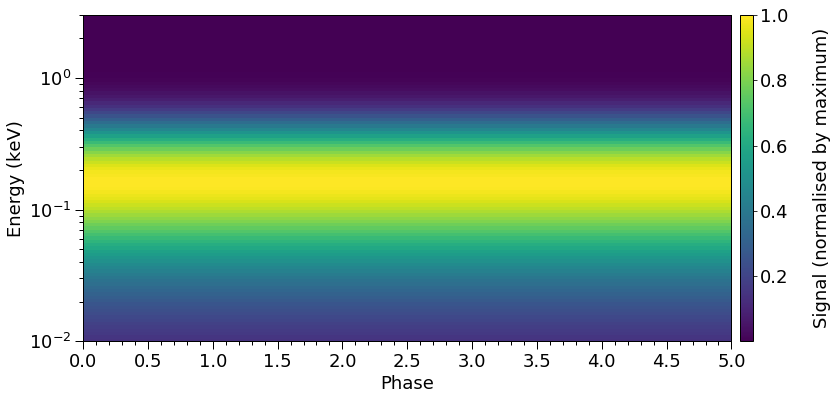

In [19]:
plot_2D_pulse(rtemp_int1,
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)')

In [20]:
everywhere.time_invariant = False # switches to xpsi/cellmesh/integrator.pyx

In [21]:
photosphere.integrate(energies=energies, threads=4)

In [22]:
rtemp_int2 = photosphere.signal[0][0].copy()

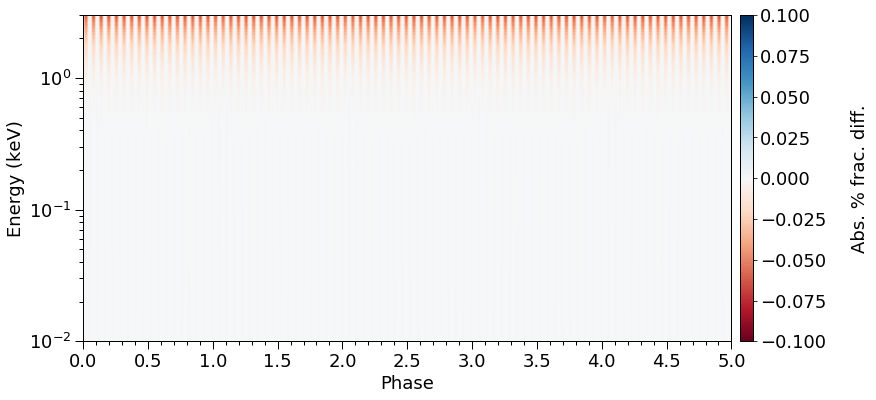

In [34]:
plot_2D_pulse(100.0*(rtemp_int2/rtemp_int1 - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-0.1, # if None just uses minimum abs. diff.
              vmax=0.1,  # if None just uses maximum abs. diff.
              normalise = False)

In [24]:
everywhere._integrator_toggle = True # switch to final integrator that discretises surface, xpsi/cellmesh/integrator_for_azimuthal_invariance.pyx, for testing

In [25]:
photosphere.integrate(energies=energies, threads=4)

In [26]:
rtemp_int3 = photosphere.signal[0][0].copy()

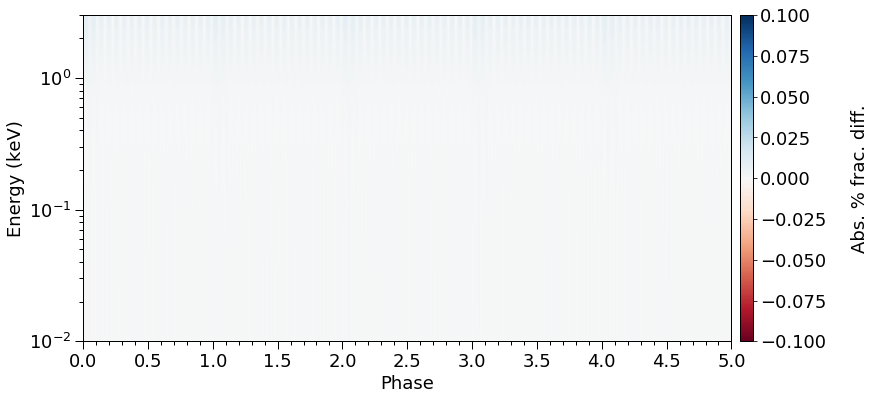

In [35]:
plot_2D_pulse(100.0*(rtemp_int3/rtemp_int1 - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-0.1, # if None just uses minimum abs. diff.
              vmax=0.1,  # if None just uses maximum abs. diff.
              normalise = False)

In [36]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

In [37]:
photosphere.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 1024,
                  # squeeze rays towards limb where higher-order images are
                  image_plane_radial_increment_power=0.33, 
                  threads = 4,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12) # ray relative tolerance

Imaging the star...
Commencing ray tracing and imaging...
Ray tracing complete.
Ray set cached.
Phase-resolved specific flux integration complete.
Star imaged.


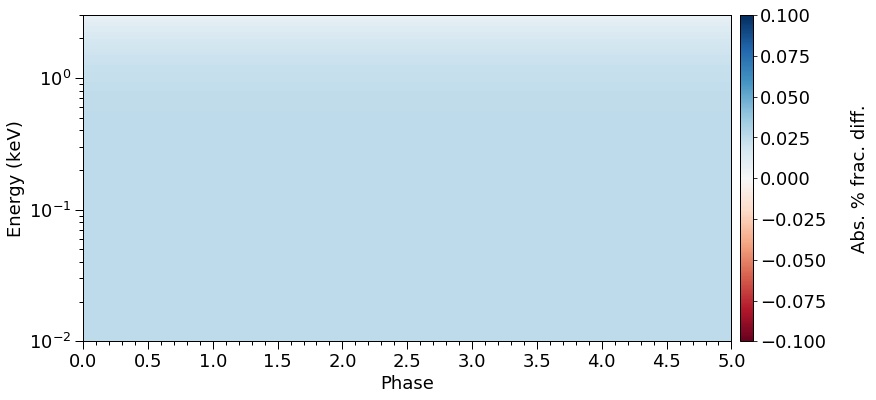

In [39]:
plot_2D_pulse(100.0*(photosphere.images[0]*spacetime.d_sq/rtemp_int1 - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-0.1,
              vmax= 0.1,
              normalise = False)

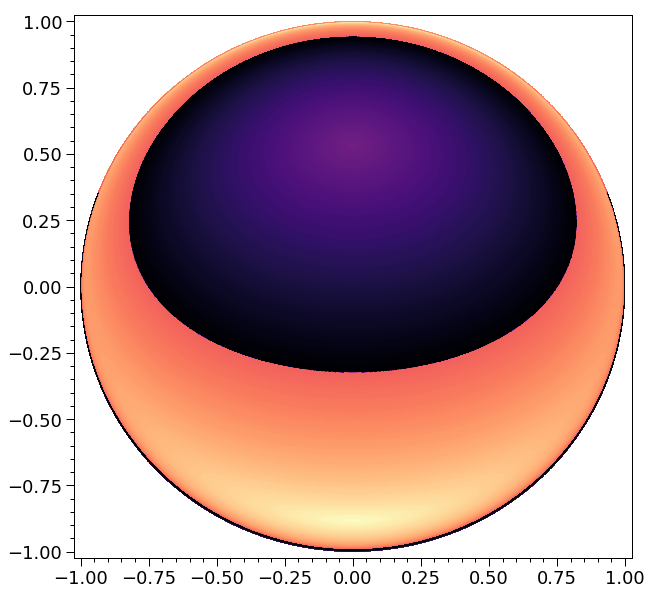

In [40]:
fig = plt.figure(figsize=(10,10))

ref = photosphere.images[3].copy()
ref[ref > math.pi/2.0] *= -1.0
plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the colatitude

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
veneer((0.05,0.25), (0.05,0.25), ax)

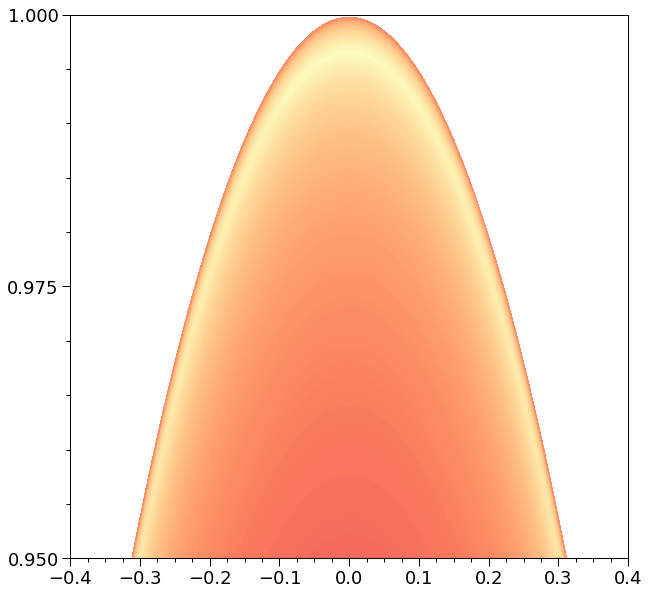

In [41]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([0.95, 1.0])
veneer((0.025,0.1), (0.005,0.025), ax)

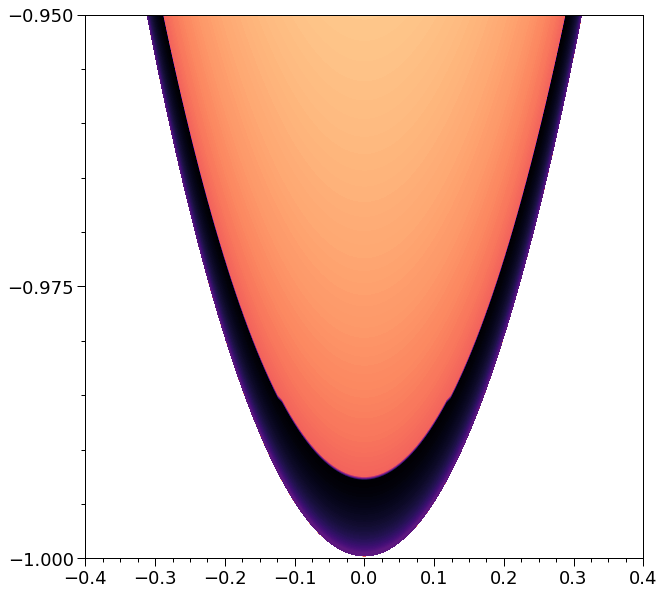

In [42]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-1.0,-0.95])
veneer((0.025,0.1), (0.005,0.025), ax)

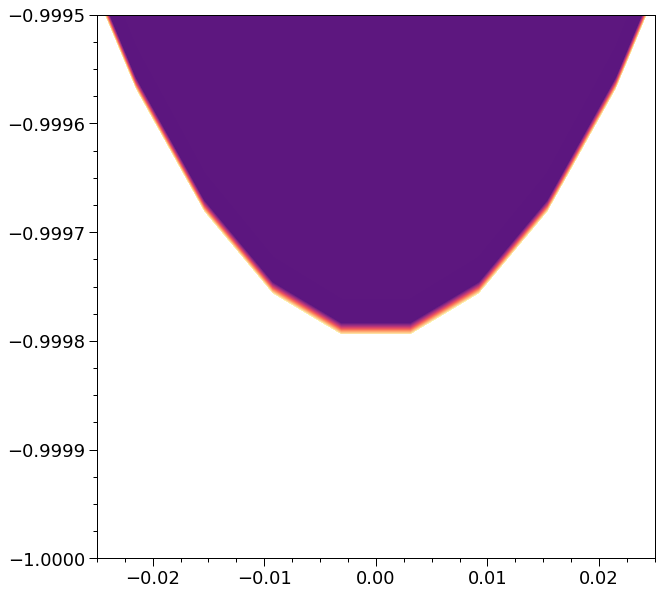

In [43]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.025,0.025])
ax.set_ylim([-1.0,-0.9995])
_ = veneer((0.0025,0.01), (0.000025,0.0001), ax)

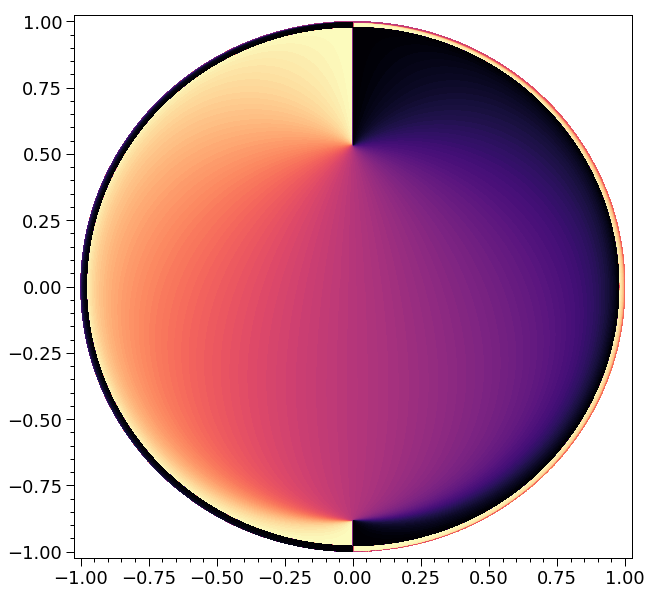

In [44]:
fig = plt.figure(figsize=(10,10))

phi = np.copy(photosphere.images[4][...])

for i in range(len(phi)):
    
    if phi[i] > -100.0:
        if phi[i] > math.pi:
            while phi[i] > math.pi:
                phi[i] -= 2.0 * math.pi
        elif phi[i] < -math.pi:
            while phi[i] < -math.pi:
                phi[i] += 2.0 * math.pi

phi_lvls = np.linspace(np.min(phi[phi > -100.0]),
                       np.max(phi[phi > -100.0]), 100)

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the azimuth

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
veneer((0.05,0.25), (0.05,0.25), ax)

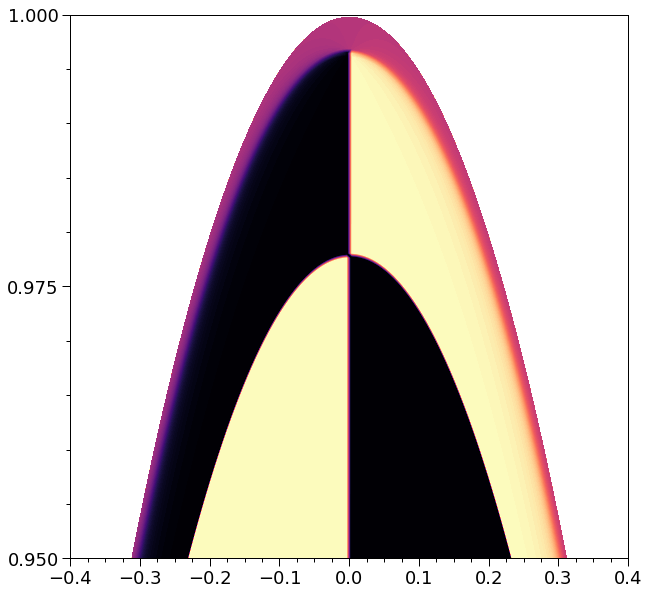

In [45]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([0.95, 1.0])
veneer((0.025,0.1), (0.005,0.025), ax)

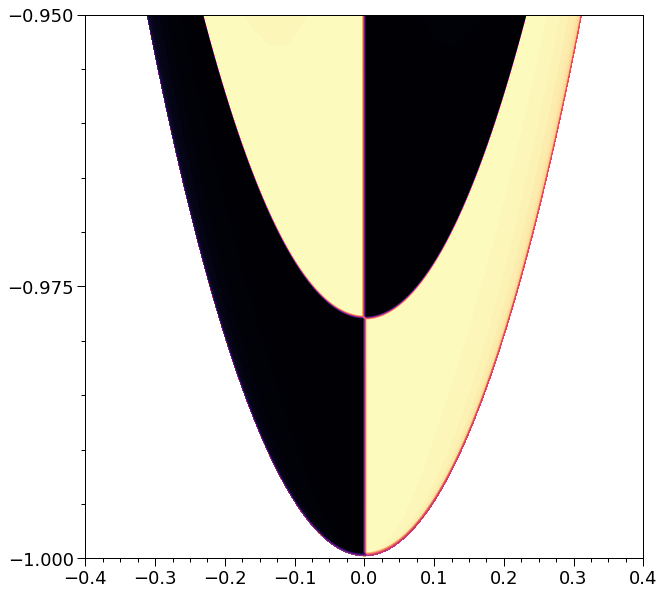

In [46]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-1.0,-0.95])
veneer((0.025,0.1), (0.005,0.025), ax)

## Custom (phase-dependent)

You now need to reinstalled the package after replacing the contents of ``xpsi/surface_radiation_field/local_variables.pyx`` with the exact contents of ``xpsi/surface_radiation_field/archive/two_spots.pyx``. The ``local_variables.pyx`` extension module must transform some set of *global* variables into *local* variables at the spacetime event defined by the intersection of a ray with the stellar surface. A vector of local variables is then passed to the ``xpsi/surface_radiation_field/hot.pyx`` module for evaluation of the specific intensity of radiation, w.r.t a local comoving surface frame, that after Lorentz transformation is transported along the ray to the image plane.

**Once you can reinstalled the package, you need to restart the IPython kernel and then execute code cells [1], [2], and [12] above.**

In [ ]:
plt.plot(photosphere.images[4].copy()[photosphere.images[4].copy()>-100.0], lw=0.1)

First we will subclass [Everywhere](everywhere.rst#xpsi.Everywhere.Everywhere) to provide a custom implementation of the surface radiation field for a surface-discretisation integrator. 

In [ ]:
class CustomEverywhere(xpsi.Everywhere):
    """ Custom radiation field globally spanning the surface. """
    
    @classmethod
    def create_parameters(cls, bounds, values={}, *args, **kwargs):
        """ Create custom parameter objects. """
        
        T = Parameter('spot_temperature',
                      strict_bounds = (3.0, 7.0), # very cold --> very hot  
                      bounds = bounds.get('spot_temperature', None),
                      doc = 'log10(spot temperature [K])',
                      symbol = r'$\log_{10}(T\;[\rm{K}])$',
                      value = values.get('spot_temperature', None))
        
        colatitude = Parameter('colatitude',
                               strict_bounds = (0.0, math.pi),
                               bounds = bounds.get('colatitude', None),
                               doc = 'spot centre colatitude [radians]',
                               symbol = r'$\Theta$',
                               value = values.get('colatitude', None))
        
        spot_scale = Parameter('spot_scale',
                               strict_bounds = (0.0, math.pi/2.0),
                               bounds = bounds.get('spot_scale', None),
                               doc = 'scale of temperature variation [radians]',
                               symbol = r'$\sigma$',
                               value = values.get('spot_scale', None))
        
        rotation = Parameter('rotation',
                             strict_bounds = (0.0, 2.0*math.pi),
                             bounds = bounds.get('rotation', None),
                             doc = 'stellar rotation [radians]',
                             symbol = r'$\phi$',
                             value = values.get('rotation', None))
        
        return cls(*args,
                   custom=[T,
                           colatitude,
                           spot_scale,
                           rotation],
                           **kwargs)
    
    @staticmethod
    def angular_separation(theta, phi, colatitude):
        """ Colatitude in rotated basis (anti-clockwise about y-axis). """
        return xpsi.HotRegion.psi(theta, phi, colatitude)
    
    def _compute_cellParamVecs(self):
        """ Custom temperature field variation to imitate hot spot + ring. """
        # all radiate, but can be changed with overwrite                                                                                    
        self._cellRadiates = np.ones(self._theta.shape, dtype=np.int32)  
        
        separation = self.angular_separation(self._theta, self._phi, self['colatitude'])
        
        self._cellParamVecs = np.ones((self._theta.shape[0],                                                                               
                                        self._theta.shape[1],                                                                               
                                        2), dtype=np.double)
        
        self._cellParamVecs[...,0] = self['spot_temperature'] * np.exp(-(separation-self['spot_scale'])**2.0/(2.0*0.25*self['spot_scale']))
        self._cellParamVecs[...,0] += self['spot_temperature'] * np.exp(-(separation-math.pi)**2.0/(2.0*self['spot_scale']))
        
        for i in range(self._cellParamVecs.shape[1]):                                                                                       
            self._cellParamVecs[:,i,-1] *= self._effGrav # unused here
            
        self._phi += self['rotation']

In [ ]:
bounds = dict(spot_temperature = (5.5, 6.5),
              colatitude = (None, None),
              spot_scale = (None, None),
              rotation = (None, None))

everywhere = CustomEverywhere.create_parameters(bounds=bounds,
                values={},            # no fixed/derived variables
                time_invariant=False, # choose appropriate integrator
                sqrt_num_cells=512,
                num_rays=1000,
                num_leaves=512,
                num_phases=100)

We want to image the photosphere and the default behaviour of [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) is insufficient. We therefore subclass [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) to provide a custom implementation of a higher-complexity radiation field. The customisation is actually very simple: we must make a property return a vector of global variable values that are relayed to a compiled extension module ``xpsi.surface_radiation_field.local_variables`` by the image-plane discretisation integrator. Thus, the bulk of the customisation must be written in ``xpsi/surface_radiation_field/local_variables.pyx`` for compilation; this has already been handled for this tutorial (see instructions above).

In [ ]:
class CustomPhotosphere(xpsi.Photosphere):
    """ Implement custom global variables property. """
    
    @property
    def global_variables(self):
        return np.array([self['spot_temperature'],
                         self['colatitude'],
                         self['spot_scale'],
                         self['rotation']])

In [ ]:
photosphere = CustomPhotosphere(hot = None,
                                elsewhere = None,
                                everywhere = everywhere,
                                values=dict(mode_frequency = spacetime['frequency']))

In [ ]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

In [ ]:
def set_defaults():
    global star # for clarity

    star['distance'] = 0.3

    star['mass'] = 2.0

    star['radius'] = 12.0

    star['cos_inclination'] = math.cos(1.0)

    star['spot_temperature'] = 6.2

    star['colatitude'] = 3.0 * math.pi/4.0
    
    star['spot_scale'] = 0.5
    
    star['rotation'] = math.pi/2.0
    
set_defaults()

In [ ]:
star.update()

In [ ]:
energies = np.logspace(-2.0, np.log10(3.0), 100, base=10.0)

In [ ]:
photosphere.integrate(energies=energies, threads=4)

In [ ]:
plot_2D_pulse(photosphere.signal[0][0],
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)')

Let's render the surface temperature field represented by our regular mesh in colatitude and azimuth:

In [ ]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
veneer((20, 100), (20, 100), ax)

z = everywhere._cellParamVecs[...,0]
patches = plt.imshow(z, rasterized = True)

Colatitude increases downwards, whilst azimuth increases rightwards. The mesh is constructed such that the $\phi\mapsto\phi-2\pi$ boundary is the meridian on which the angular centre of the ring lies. We can make a crude plot of the surface temperature field in a more natural way:

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(111, projection="lambert")
plt.grid(True)

Lat = -everywhere._theta + math.pi/2.0

z = everywhere._cellParamVecs[...,0]

plt.contour(everywhere._phi, Lat, z,
            levels=np.linspace(np.min(z), np.max(z), 50))

_ = plt.gca().set_xticklabels([])

Note that although the star looks lensed, it is merely a projection (mimicking Scwarzschild light bending for an equatorial observer) that allows us to render all $4\pi$ steradians of the surface. The real lensing is yet to come! First we need to force our exterior spacetime to be that of Schwarzschild:

In [ ]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

Now call the imaging routine in the same manner as above:

In [ ]:
photosphere.image(reimage = True,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 1000, # because why not?
                  threads = 4,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12)

Let's examine the phase-energy resolved photon specific flux signal and compare it to the signal computed by via surface discretisation:

In [ ]:
plot_2D_pulse(np.ascontiguousarray(photosphere.images[0]),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)')

In [ ]:
plot_2D_pulse(100.0*(photosphere.images[0]*spacetime.d_sq/photosphere.signal[0][0] - 1.0),
              x=everywhere.phases_in_cycles,
              shift=np.array([0.0]),
              y=energies,
              ylabel=r'Energy (keV)',
              cm=cm.RdBu,
              label=r"Abs. % frac. diff.",
              vmin=-1.0,
              vmax=1.0,
              normalise=False)

Now the really fun part: photon specific intensity sky maps. Now that we are not pursuing a high-resolution signal to compare to an integrator that discretises the stellar surface, we reduce the number of energies and rays to avoid memory issues when caching the sky photon specific intensity field in four dimensions. Nevertheless, if you run these cells as is, you might want to grab a beverage of choice while you wait up to ~30 minutes. **Moreover, up to ~20 GB of RAM might be needed by the animator. You can deactivate the animator if this is problematic, and handle the image files via some other mode.**

In [ ]:
sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5),
                  'num_levels': 100, # in intensity field rendering
                  'colormap': cm.Greys_r,
                  'phase_average': False}
    
# edit the ffmpeg path for your system and activate the animator below
# you can install ffmpeg with conda
animate_kwargs = {'cycles': 8,
                  'ffmpeg_path': '/home/thomas/miniconda2/envs/xpsi/bin/ffmpeg',
                  'fps': 32}

In [ ]:
photosphere.image(reimage = True,
                  cache_intensities = 1.0, # cache size limit in GBs
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 400,
                  threads = 4,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12,
                  plot_sky_maps = True, # activate if you want to plot frames
                  sky_map_kwargs = sky_map_kwargs, # activate if you want to animate (BEWARE high memory usage)
                  animate_sky_maps = True,
                  free_memory = False, # activate if memory is a concern
                  animate_kwargs = animate_kwargs)

# To reduce animation memory requirements, you can reduce the number of phases.
# If phase-averaging only, it is safe to increase the phase resolution
# to remove artefacts, but start with a smaller number of phases if you
# want to plot phase-resolved sky map frames and animate the sequence
# in order to get a handle on the memory requirements.

If you are executing this notebook, you can view the video file:

In [ ]:
%%HTML
<div align="middle">
<video width="100%" controls loop>                                                                                                                   
    <source src="images/skymap_animated.mp4" type="video/mp4">                                                                     
</video></div>

In [ ]:
!mkdir images/frames
!mv images/*.png images/frames/.

Here is a frame for the purpose of the documentation notebook. Each panel displays the photon specific intensity field, on the sky, at a given energy; energy increases from top-left to bottom-right. The intensity field in each panel is normalised over sky direction and phase, for each energy in the sequence.

In [ ]:
Image("./images/frames/skymap_50.png")

Finally, let's phase-average the intensity sky maps:

In [ ]:
sky_map_kwargs['phase_average'] = True
# only one set of panels so why not choose higher res.?
sky_map_kwargs['num_levels'] = 500

photosphere.image(reimage = False, # because we decided not to free_memory earlier
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = everywhere.phases_in_cycles * _2pi,
                  plot_sky_maps = True,
                  sky_map_kwargs = sky_map_kwargs)

In [ ]:
!mv images/skymap_0.png images/skymap_phase_averaged_spot_and_ring.png

In [ ]:
Image("images/skymap_phase_averaged_spot_and_ring.png")

To understand the phase-averaged intensity field associated with the ring, consider a fix sky direction through which the upper and lower extremities (in colatitude) of the ring pass as the star rotates. The bright surface regions pass over such sky directions for a greater fraction of the one revolution than for sky directions closer in surface colatitude to the centre of the ring.

## Rotating spacetime

The integrator that discretises an image plane, being more general purpose (but not as general purpose as a number of other open-source codes), can also handle a rotating spacetime via a CPU-based implementation of the quasi-Kerr formalism  [Psaltis & Johannsen (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...745....1P/abstract) and [Bauböck et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...753..175B/abstract), in which the exterior spacetime solution has a finite angular momentum and mass quadrupole moment. If we delete the custom values of these spacetime variables, universal relations from [AlGendy & Morsink (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...791...78A/abstract) will be invoked.

In [ ]:
del spacetime.a
del spacetime.q

In [ ]:
spacetime.a # dimensions of length

In [ ]:
spacetime.q # dimensionless

In [ ]:
sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5),
                  'num_levels': 500, # in intensity field rendering
                  'colormap': cm.Greys_r,
                  'phase_average': True}

photosphere.image(reimage = True,
                  reuse_ray_map = False, # have to do manually because free parameters have not changed
                  cache_intensities = 1.0, # cache size limit in GBs
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 400,
                  threads = 4,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12,
                  plot_sky_maps = True,
                  sky_map_kwargs = sky_map_kwargs)

In [ ]:
!mv images/skymap_0.png images/skymap_phase_averaged_spot_and_ring__rotating_spacetime.png

In [ ]:
Image("images/skymap_phase_averaged_spot_and_ring__rotating_spacetime.png")

You should be able to detect the extra lateral asymmetry introduced at lower energies that was not present for a static ambient spacetime.

Note that the temporal and azimuthal coordinates are no longer those used above for the Schwarzschild exterior spacetime solution, and thus the surface radiation field is inherently different when the same functions of azimuthal and temporal coordinates are used to construct it.

The integrator can also handle some forms of time evolution of the surface radiation field beyond pure bulk rotation, but such a usage pattern is more advanced and thus left for a future tutorial.